# Motivation of using GINI Initialization 

Experiments on 4 datasets：
* Two Synthetic datasets that we know the ground truth
* Two Realworld datasets we insert Noise

---
Madelon

In [229]:
from scipy.io import loadmat
from scipy.sparse import issparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
mat = loadmat("Data/madelon.mat")
X = mat["X"]
y = mat["Y"]
if issparse(X):
    X = X.todense()
y = y.flatten()
y[np.where(y == -1)] = 0
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X.shape, y.shape)

(2600, 500) (2600,)


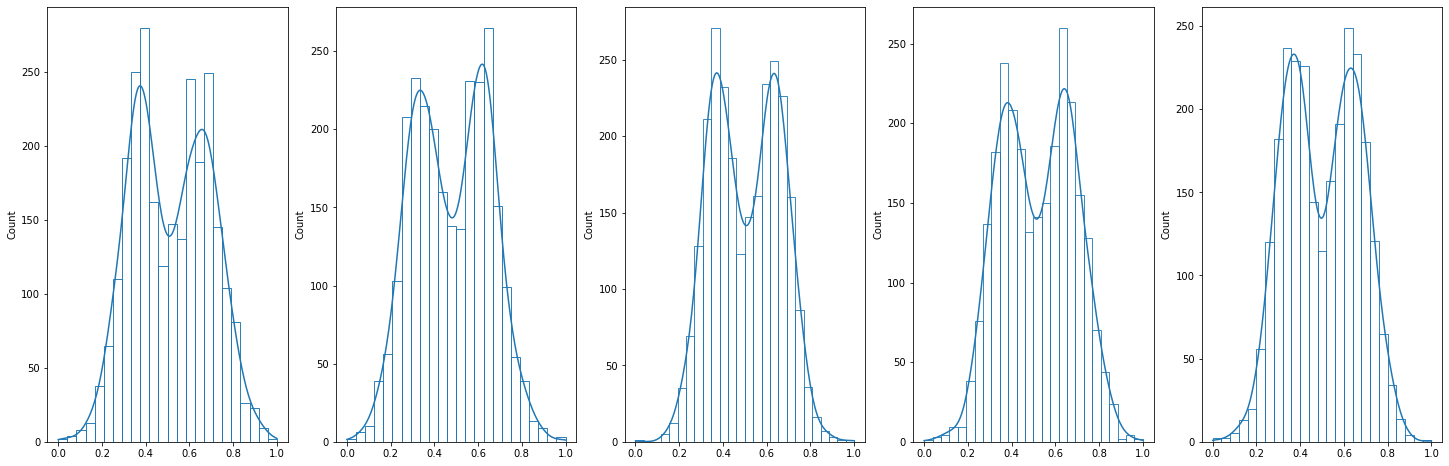

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 8))
for i, base_feature_idx in enumerate([28, 48, 153, 241, 455]):
  sns.histplot(X[:, base_feature_idx], ax=axs[i], kde=True, fill=False)
plt.show()

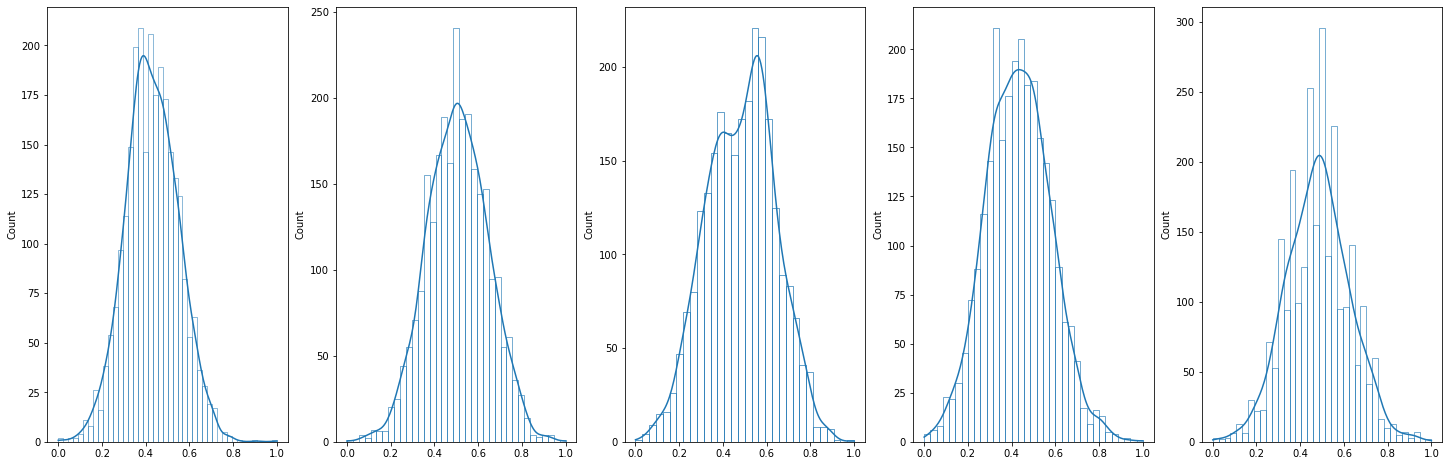

In [231]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 8))
for i, feature_idx in enumerate(np.random.choice(list(range(0, 500)), 5)):
  sns.histplot(X[:, feature_idx], ax=axs[i], kde=True, fill=False)
plt.show()

In [232]:
correct_label = np.zeros(X.shape[1])
correct_label[[28, 48, 153, 241, 455]] = 1
print(np.count_nonzero(correct_label))

5


Can gini filter find the noisy feature

In [233]:
from sklearn.metrics import accuracy_score

In [234]:
from Gini import gini_score_fast_old
from sklearn.metrics import f1_score
import torch
accs = []
percentages = []
X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.long)
g_score = gini_score_fast_old(X, y)
for percentage in [5] + list(np.arange(0.1, 1, 0.05)):
    index = np.argsort(g_score)
    if isinstance(percentage, float):
        index_left = index[:int(percentage*len(index))]
    else:
        index_left = index[:percentage]
        percentage = 0
        print(index_left)
    pred_label = np.zeros_like(correct_label)
    pred_label[index_left] = 1
    percentages.append(percentage)
    acc = accuracy_score(correct_label, pred_label)
    accs.append(acc)
    #print(acc, percentage)

tensor([241, 338, 475, 128, 105])


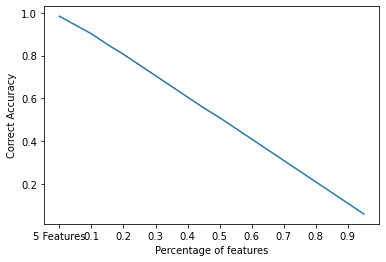

In [235]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(percentages, accs)
plt.xlabel('Percentage of features')
plt.ylabel('Correct Accuracy')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "5 Features"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels)
plt.show()

---
SFFS

In [236]:
X = X.numpy()
y = y.numpy()

In [237]:
from SFFS import get_f_stat_index
index = get_f_stat_index(X, y)
sffs_accs = []
for percentage in [5] + list(np.arange(0.1, 1, 0.05)):
    index = np.argsort(g_score)
    if isinstance(percentage, float):
        index_left = index[:int(percentage*len(index))]
    else:
        index_left = index[:percentage]
        percentage = 0
    pred_label = np.zeros_like(correct_label)
    pred_label[index_left] = 1
    acc = accuracy_score(correct_label, pred_label)
    sffs_accs.append(acc)

total computation time for pinv is: 0.037899017333984375


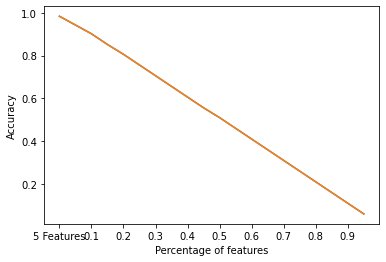

In [238]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
plt.xlabel('Percentage of features')
plt.ylabel('Accuracy')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "5 Features"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels)
ax.plot(percentages, accs)
ax.plot(percentages, sffs_accs)
plt.show()

In [239]:
from Data import VFLDataset
dataset = VFLDataset(data_source=(X, y), 
                    num_clients=1,
                    insert_noise=False)

Client 0: Feature Index 0-249
Server : Feature Index 250-499


In [240]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset.train(), batch_size=128, shuffle=True)
val_loader = DataLoader(dataset.valid(), batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset.test(), batch_size=1000, shuffle=True)

In [241]:
import VFL
gini_stg_accs = {
    'percentage': [],
    'acc': [],
}
stg_percentages = [5] +list(np.arange(0.1, 1, 0.1))
for _ in range(3):
    for percentage in stg_percentages:
        if percentage == 5:
            percentage = 0
        gini_labels = dataset.gini_filter(percentage)
        feat_idx_list = dataset.get_feature_index_list()
        input_dim_list = dataset.get_input_dim_list()
        mus = VFL.initialize_mu(gini_labels, feat_idx_list)
        models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=64,
                            output_dim=2, hidden_dims=[256, 256],
                            activation='relu', mus=mus, lam=0.1)
        VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=40, lr=0.01, optimizer='Adam',verbose=False, save_mask_at=10000, 
                criterion=torch.nn.CrossEntropyLoss())
        z_list = []
        for model in models:
            z, num_feat = model.get_gates()
            z_list.append(z)
        z_pred = np.concatenate(z_list)
        z_pred = z_pred >= 1e-5
        # print(np.nonzero(z_pred))
        # print(np.nonzero(correct_label))
        acc = accuracy_score(correct_label, z_pred)
        print(percentage, acc)
        gini_stg_accs['acc'].append(acc)
        gini_stg_accs['percentage'].append(percentage)

0 0.99
0.1 0.958
0.2 0.942
0.30000000000000004 0.842
0.4 0.896
0.5 0.918
0.6 0.93
0.7000000000000001 0.872
0.8 0.924
0.9 0.572
0 0.99
0.1 0.97
0.2 0.986
0.30000000000000004 0.786
0.4 0.948
0.5 0.774
0.6 0.602
0.7000000000000001 0.97
0.8 0.688
0.9 0.58
0 0.99
0.1 0.958
0.2 0.972
0.30000000000000004 0.824
0.4 0.946
0.5 0.928
0.6 0.964
0.7000000000000001 0.674
0.8 0.968
0.9 0.87


In [242]:
import VFL
stg_accs = {
    'percentage': [],
    'acc': [],
}
stg_percentages = [5] +list(np.arange(0.1, 1, 0.1))
for _ in range(3):
    for percentage in stg_percentages:
        if percentage == 5:
            percentage = 0
        # gini_labels = dataset.gini_filter(percentage)
        # feat_idx_list = dataset.get_feature_index_list()
        input_dim_list = dataset.get_input_dim_list()
        # mus = VFL.initialize_mu(gini_labels, feat_idx_list)
        models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=64,
                            output_dim=2, hidden_dims=[256, 256],
                            activation='relu', mus=mus, lam=0.1)
        VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=40, lr=0.01, optimizer='Adam',verbose=False, save_mask_at=10000, 
                criterion=torch.nn.CrossEntropyLoss())
        z_list = []
        for model in models:
            z, num_feat = model.get_gates()
            z_list.append(z)
        z_pred = np.concatenate(z_list)
        z_pred = z_pred >= 1e-5
        # print(np.nonzero(z_pred))
        # print(np.nonzero(correct_label))
        acc = accuracy_score(correct_label, z_pred)
        print(percentage, acc)
        stg_accs['acc'].append(acc)
        stg_accs['percentage'].append(percentage)

0 0.946
0.1 0.754
0.2 0.422
0.30000000000000004 0.764
0.4 0.726
0.5 0.752
0.6 0.588
0.7000000000000001 0.506
0.8 0.706
0.9 0.748
0 0.858
0.1 0.802
0.2 0.906
0.30000000000000004 0.68
0.4 0.72
0.5 0.766
0.6 0.986
0.7000000000000001 0.946
0.8 0.876
0.9 0.672
0 0.442
0.1 0.646
0.2 0.732
0.30000000000000004 0.718
0.4 0.98
0.5 0.65
0.6 0.896
0.7000000000000001 0.788
0.8 0.584
0.9 0.738


---
To reproduce and replot the figure


In [244]:
import dill 
dill.load_session('gini_stg_motivation.db')

FileNotFoundError: [Errno 2] No such file or directory: 'gini_stg_motivation.db'

---


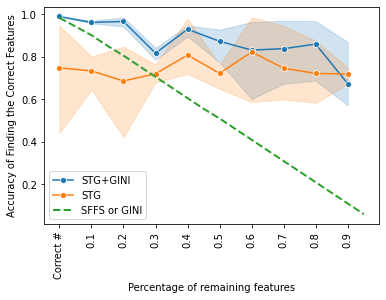

In [263]:
import pandas as pd
fig, ax = plt.subplots() 
plt.xlabel('Percentage of remaining features')
plt.ylabel('Accuracy of Finding the Correct Features')
sns.lineplot(data=pd.DataFrame(gini_stg_accs), x='percentage', y='acc',
   label="STG+GINI", marker='o')
sns.lineplot(data=pd.DataFrame(stg_accs), x='percentage', y='acc', 
    label="STG", marker='o')
ax.plot(percentages, sffs_accs, '--', linewidth=2, label='SFFS or GINI')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "Correct #"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels, rotation=90)
plt.legend()
plt.show()

In [247]:
import dill
dill.dump_session('gini_stg_motivation.db')

---

why use gini to initialize

In [248]:
import os
DIR = "Data"
file_name = 'arcene.mat'
mat = loadmat(os.path.join(DIR, file_name))
X = mat["X"]
y = mat["Y"]
if issparse(X):
    X = X.todense()
y = y.flatten()
print(file_name, X.shape, y.shape)
y[np.where(y == -1)] = 0
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
dataset = VFLDataset(data_source=(X, y), 
                    num_clients=3,
                    gini_portion=None,
                    insert_noise=False,
                    test_size=0.5)
train_loader = DataLoader(dataset.train(), batch_size=128, shuffle=True)
val_loader = DataLoader(dataset.valid(), batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset.test(), batch_size=1000, shuffle=True)
input_dim_list = dataset.get_input_dim_list()
output_dim = np.unique(y).size
criterion = torch.nn.CrossEntropyLoss()

arcene.mat (200, 10000) (200,)
Client 0: Feature Index 0-2499
Client 1: Feature Index 2500-4999
Client 2: Feature Index 5000-7499
Server : Feature Index 7500-9999


In [249]:
X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.long)
g_score = gini_score_fast_old(X, y)
index = np.argsort(g_score)
index_left = index[:int(0.5*len(index))]
half_pred_labels = np.zeros(X.shape[1])
half_pred_labels[index_left] = 1

In [250]:
X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.long)
g_score = gini_score_fast_old(X, y)
index = np.argsort(g_score)
index_left = index[:int(0.25*len(index))]
quarter_pred_labels = np.zeros(X.shape[1])
quarter_pred_labels[index_left] = 1

C:\Users\HONGYI~1\AppData\Local\Temp/ipykernel_5320/694827315.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\HONGYI~1\AppData\Local\Temp/ipykernel_5320/694827315.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


In [251]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [252]:
def selected_intersection(pred, true):
    pred_selected = np.nonzero(pred)
    true_seleceted = np.nonzero(true)
    intersection = np.intersect1d(pred_selected, true_seleceted)
    # intersection_rate = len(intersection) / len(pred_selected)
    return len(intersection)

In [253]:
def rejected_intersection(pred, true):
    pred_selected = np.argwhere(pred==0)
    true_seleceted = np.argwhere(true==0)
    intersection = np.intersect1d(pred_selected, true_seleceted)
    return len(intersection)

In [254]:
intersection_gini_stg = {
  
    'round': np.arange(0, 200, 10),
    'acc': [],
    'selected intersection': [],
    'rejected intersection': [],
}
models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=4,
                            output_dim=output_dim, hidden_dims=[16, 8],
                            activation='relu', lam=0.1)
steps = [10]*20
for step in steps:
    VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=step, lr=0.01, optimizer='Adam',verbose=False, save_mask_at=10000, 
                criterion=criterion)
    z_list= []
    for model in models:
        z, num_feat = model.get_gates()
        z_list.append(z)
    z_pred = np.concatenate(z_list)
    z_pred = z_pred >= 1e-5
    print('features left', np.count_nonzero(z_pred))
    print('Selected Intersection', selected_intersection(z_pred, half_pred_labels))
    intersection_gini_stg['selected intersection'].append(selected_intersection(z_pred, half_pred_labels))
    print('Rejected Intersection', rejected_intersection(z_pred, half_pred_labels))
    intersection_gini_stg['rejected intersection'].append(rejected_intersection(z_pred, half_pred_labels))
    intersection_gini_stg['acc'].append(accuracy_score(half_pred_labels, z_pred))
    # print('Intersection', selected_intersection(z_pred, half_pred_labels))
            

features left 10000
Selected Intersection 5000
Rejected Intersection 0
features left 10000
Selected Intersection 5000
Rejected Intersection 0
features left 10000
Selected Intersection 5000
Rejected Intersection 0
features left 10000
Selected Intersection 5000
Rejected Intersection 0
features left 9945
Selected Intersection 5000
Rejected Intersection 55
features left 9711
Selected Intersection 4986
Rejected Intersection 275
features left 9462
Selected Intersection 4928
Rejected Intersection 466
features left 8877
Selected Intersection 4724
Rejected Intersection 847
features left 8326
Selected Intersection 4503
Rejected Intersection 1177
features left 7749
Selected Intersection 4238
Rejected Intersection 1489
features left 7125
Selected Intersection 3920
Rejected Intersection 1795
features left 6384
Selected Intersection 3523
Rejected Intersection 2139
features left 5620
Selected Intersection 3096
Rejected Intersection 2476
features left 4898
Selected Intersection 2713
Rejected Intersect

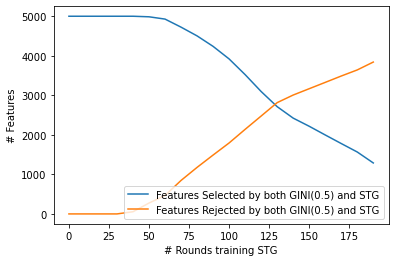

In [255]:
plt.plot(intersection_gini_stg['round'], intersection_gini_stg['selected intersection'],
    label='Features Selected by both GINI(0.5) and STG')
plt.plot(intersection_gini_stg['round'], intersection_gini_stg['rejected intersection'],
    label='Features Rejected by both GINI(0.5) and STG')
plt.ylabel("# Features")
plt.xlabel("# Rounds training STG")
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy of STG and GINI half')

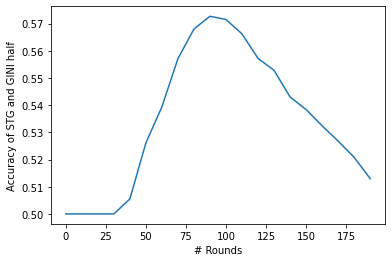

In [256]:
plt.plot(intersection_gini_stg['round'], intersection_gini_stg['acc'])
plt.xlabel("# Rounds")
plt.ylabel("Accuracy of STG and GINI half")

In [257]:
%%capture
models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=4,
                            output_dim=output_dim, hidden_dims=[16, 8],
                            activation='relu', lam=0.1)
stg_results =  VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=200, lr=0.01, optimizer='Adam',verbose=True, save_mask_at=10000, 
                criterion=criterion)

In [258]:
%%capture
gini_labels = dataset.gini_filter(0.5)
feat_idx_list = dataset.get_feature_index_list()
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=4,
                            output_dim=output_dim, hidden_dims=[16, 8],
                            activation='relu', lam=0.1, mus=mus)
stg_gini_results = VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=200, lr=0.01, optimizer='Adam',verbose=True, save_mask_at=10000, 
                criterion=criterion)

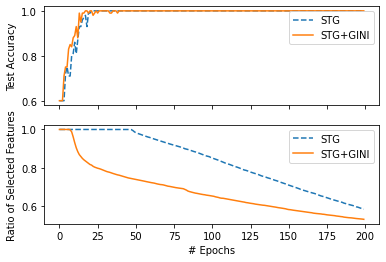

In [262]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(stg_results['test_acc'], label='STG', linestyle='--')
ax1.plot(stg_gini_results['test_acc'], label='STG+GINI')
ax1.set_ylabel('Test Accuracy')
ax1.legend()
ax2.plot(stg_results['num_feats']/10000, label='STG', linestyle='--')
ax2.plot(stg_gini_results['num_feats']/10000, label='STG+GINI')
ax2.set_ylabel("Ratio of Selected Features")
ax2.legend()
plt.xlabel("# Epochs")
plt.show()

In [260]:
import dill
dill.dump_session('gini_stg_motivation.db')

In [261]:
import dill 
dill.load_session('gini_stg_motivation.db')